In [98]:
import pandas as pd
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import urllib
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
funnel_df = pd.read_csv('data/funnel.csv')
funnel_df.head()

,user_id,conversion,revenue
0,1,False,NaN
1,2,False,NaN
2,3,False,NaN
3,4,False,NaN
4,5,False,NaN


In [100]:
touches_df = pd.read_csv('data/touches.csv')
touches_df.head()

,user_id,channel,timestamp
0,1,retention,2017-04-02
1,2,digital,2015-06-02
2,2,digital,2015-10-25
3,2,digital,2017-02-15
4,3,retention,2017-05-07


In [101]:
test = touches_df[touches_df['channel'] == "retention"]
test.head()

,user_id,channel,timestamp
0,1,retention,2017-04-02
4,3,retention,2017-05-07
14,5,retention,2017-05-20
15,18228,retention,2017-05-20
42,7,retention,2017-04-10


In [102]:
date = pd.to_datetime(touches_df['timestamp'])
touches_df['timestamp'] = date
touches_df['timestamp'] = touches_df['timestamp'].map(dt.datetime.toordinal)

In [103]:
touches_df.head()

,user_id,channel,timestamp
0,1,retention,736421
1,2,digital,735751
2,2,digital,735896
3,2,digital,736375
4,3,retention,736456


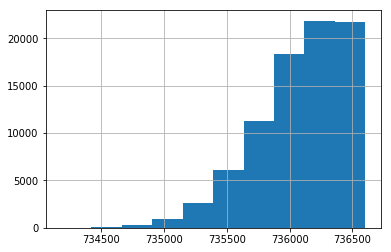

In [104]:
touches_df['timestamp'].hist()

In [105]:
df = funnel_df.merge(touches_df, on='user_id')
df.head()

,user_id,conversion,revenue,channel,timestamp
0,1,False,NaN,retention,736421
1,2,False,NaN,digital,735751
2,2,False,NaN,digital,735896
3,2,False,NaN,digital,736375
4,3,False,NaN,retention,736456


In [106]:
df.describe()

,user_id,revenue,timestamp
count,83184.000000,10052.000000,83184.000000
mean,11046.768225,1246.808949,736082.114060
std,6361.487434,1108.479019,356.398941
min,1.000000,0.000000,734177.000000
25%,5506.750000,452.904499,735866.000000
50%,11080.000000,928.140692,736139.000000
75%,16543.000000,1676.773694,736370.000000
max,22047.000000,4427.412837,736602.000000


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83184 entries, 0 to 83183
Data columns (total 5 columns):
user_id       83184 non-null int64
conversion    83184 non-null bool
revenue       10052 non-null float64
channel       83184 non-null object
timestamp     83184 non-null int64
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 3.3+ MB


In [108]:
df = df.fillna(value=0)

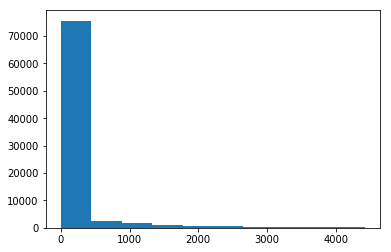

In [12]:
revenue = df['revenue'].values
plt.hist(revenue);

In [109]:
conversion_dum = pd.get_dummies(df['conversion'])
df = pd.concat([df, conversion_dum], axis=1)
df = df.drop('conversion', axis=1)
df.head()

,user_id,revenue,channel,timestamp,False,True
0,1,0.0,retention,736421,1,0
1,2,0.0,digital,735751,1,0
2,2,0.0,digital,735896,1,0
3,2,0.0,digital,736375,1,0
4,3,0.0,retention,736456,1,0


In [110]:
channel_dum = pd.get_dummies(df['channel'])
df = pd.concat([df, channel_dum], axis=1)
df = df.drop('channel', axis=1)
df.head()

,user_id,revenue,timestamp,False,True,digital,offline,organic,retention
0,1,0.0,736421,1,0,0,0,0,1
1,2,0.0,735751,1,0,1,0,0,0
2,2,0.0,735896,1,0,1,0,0,0
3,2,0.0,736375,1,0,1,0,0,0
4,3,0.0,736456,1,0,0,0,0,1


In [15]:
#df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime("%Y%m%d")

In [90]:
date = pd.to_datetime(df['timestamp'])
df['timestamp'] = date
df['timestamp'] = df['timestamp'].map(dt.datetime.toordinal)

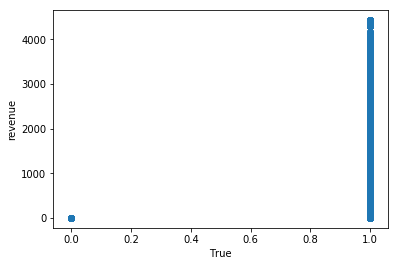

In [17]:
for feature in [True]:
    plt.scatter(df[feature], df['revenue'])
    plt.xlabel(feature)
    plt.ylabel('revenue')
    plt.show()

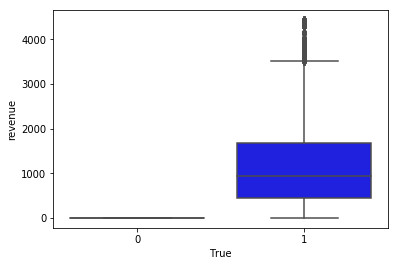

In [18]:
for feature in [True]:
    sns.boxplot(x=feature, y='revenue', color= 'b', data=df)
    plt.show()

### including non_conversions (original)

In [19]:
y = df['revenue']
X = df.drop(['revenue'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

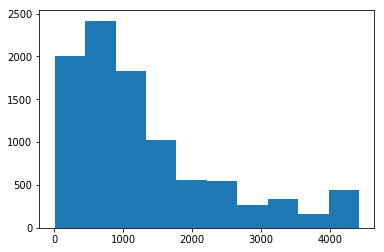

In [21]:
rev_df = df[df['revenue'] != 0]
plt.hist(rev_df['revenue']);

In [22]:
#revenue mean excluding non-converted users

rev_df['revenue'].mean()

1306.6017053230862

In [23]:
#revenue mean including all users

df['revenue'].mean()

150.66507450301793

In [24]:
(y_test - y_train.mean()).abs().mean()

269.338797770107

In [25]:
# use for MAE because of skew

(y_test - y_train.median()).abs().mean()

153.27292483467548

In [34]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)
linear_mae = mean_absolute_error(y_test, lm_predictions)
linear_mae

110.0495953357125

In [27]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mae

74.22447233115699

In [28]:
rf = RandomForestRegressor(random_state=42, n_estimators=10)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mae

36.915110456817224

### exluding non_conversions

In [156]:
y = rev_df['revenue']
X = rev_df.drop(['revenue'], axis=1)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)
linear_mae = mean_absolute_error(y_test, lm_predictions)
linear_mae

866.6716853780368

In [159]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mae

483.17022372320207

In [160]:
rf = RandomForestRegressor(random_state=42, n_estimators=10)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mae

292.22364457823056

### classification of converters

In [29]:
y_convert = df[True]
X_convert = df.drop(['revenue', True, False], axis=1)

In [32]:
X_con_train, X_con_test, y_con_train, y_con_test = train_test_split(X_convert, y_convert, test_size=0.2)

In [36]:
log = linear_model.LogisticRegression()
log_model = log.fit(X_con_train, y_con_train)
log_predictions = log_model.predict(X_con_test)
log_mae = mean_absolute_error(y_con_test, log_predictions)
log_mae

/Users/Beto/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


30.08745567109455

In [113]:
digital = df[df['digital'] == 1]
digital.head()

,user_id,revenue,timestamp,False,True,digital,offline,organic,retention
1,2,0.0,735751,1,0,1,0,0,0
2,2,0.0,735896,1,0,1,0,0,0
3,2,0.0,736375,1,0,1,0,0,0
5,4,0.0,735490,1,0,1,0,0,0
6,4,0.0,735860,1,0,1,0,0,0


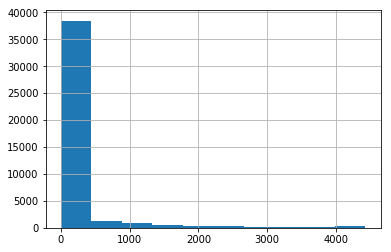

In [114]:
digital['revenue'].hist()

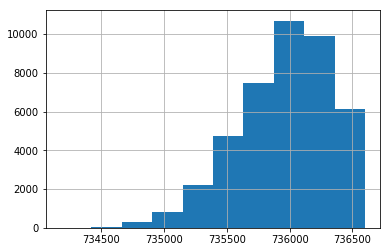

In [125]:
digital['timestamp'].hist()

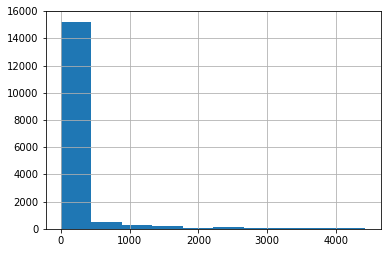

In [76]:
offline = df[df['offline'] == 1]
offline['revenue'].hist()

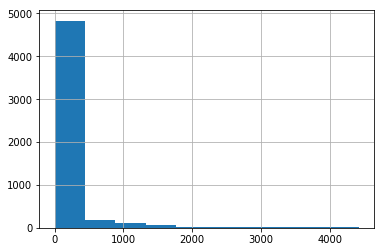

In [78]:
organic = df[df['organic'] == 1]
organic['revenue'].hist()

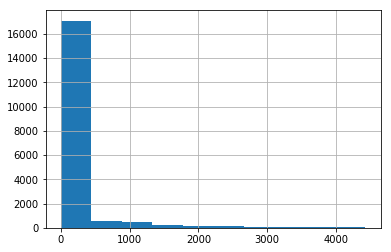

In [79]:
retention = df[df['retention'] == 1]
retention['revenue'].hist()

In [89]:
df.head()

,user_id,revenue,timestamp,False,True,digital,offline,organic,retention
0,1,0.0,719163,1,0,0,0,0,1
1,2,0.0,719163,1,0,1,0,0,0
2,2,0.0,719163,1,0,1,0,0,0
3,2,0.0,719163,1,0,1,0,0,0
4,3,0.0,719163,1,0,0,0,0,1


In [ ]:
#check if non_converts are similar

In [37]:
df.head()

,user_id,revenue,timestamp,False,True,digital,offline,organic,retention
0,1,0.0,719163,1,0,0,0,0,1
1,2,0.0,719163,1,0,1,0,0,0
2,2,0.0,719163,1,0,1,0,0,0
3,2,0.0,719163,1,0,1,0,0,0
4,3,0.0,719163,1,0,0,0,0,1


In [51]:
non = df[df[False]==1]

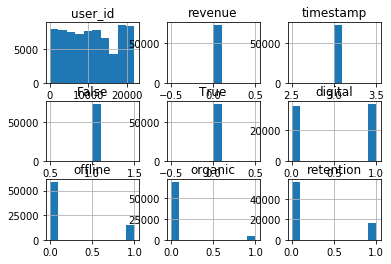

In [67]:
non.hist();

In [54]:
non.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73132 entries, 0 to 83183
Data columns (total 9 columns):
user_id      73132 non-null int64
revenue      73132 non-null float64
timestamp    73132 non-null int64
False        73132 non-null uint8
True         73132 non-null uint8
digital      73132 non-null uint8
offline      73132 non-null uint8
organic      73132 non-null uint8
retention    73132 non-null uint8
dtypes: float64(1), int64(2), uint8(6)
memory usage: 2.7 MB


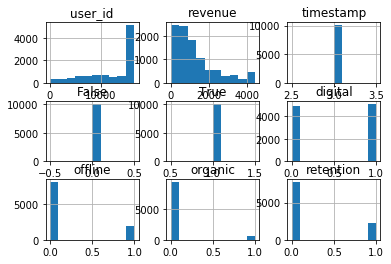

In [68]:
yes = df[df[True]==1]
yes.hist();

In [56]:
yes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10052 entries, 17 to 62228
Data columns (total 9 columns):
user_id      10052 non-null int64
revenue      10052 non-null float64
timestamp    10052 non-null int64
False        10052 non-null uint8
True         10052 non-null uint8
digital      10052 non-null uint8
offline      10052 non-null uint8
organic      10052 non-null uint8
retention    10052 non-null uint8
dtypes: float64(1), int64(2), uint8(6)
memory usage: 373.0 KB


In [61]:
mask = yes[yes['user_id'] > 15500]

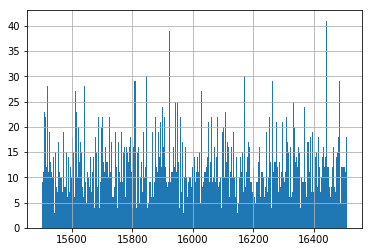

In [63]:
mask['user_id'].hist(bins = 300)